In [1]:
import warnings
from importlib import reload
from functools import partial, lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tabulate import tabulate
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from sklearn.metrics.pairwise import paired_distances, euclidean_distances
import scipy
from traceback_with_variables import printing_exc, ColorSchemes, Format

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
import libdatasets
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch
from libutil import ProgressParallel
from libdatasets import *
import librun
from librun import run

Using sklearn


In [2]:
def bias(X_train, X_test, y_train, y_test, rand=None, config_str=None, **kwargs):
    dataset_str = config_str.split("__")[0]
    func = {
        "banknote": bias_banknote,
        "abalone": bias_abalone,
        "car": bias_car,
        "cardio": bias_cardio,
        "shuttle": bias_shuttle,
        "skin": bias_skin,
    }
    X_train, y_train = func[dataset_str](X_train, y_train)
    return X_train, X_test[:,:-1], y_train, y_test

In [3]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("car", lambda: lru_cache()(car)()),
        ("cardio", lambda: lru_cache()(cardio)(1000)),
        ("shuttle", lambda: lru_cache()(shuttle)(1000)),
        ("skin", lambda: lru_cache()(skin)(1000)),
    ],
    "dataset_mutators": {
        #"none": (lambda *x, **kwargs: x),
        "bias": bias,
    },
    "methods": [
        ("random", partial(random_batch, n_instances=10)),
        ("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
        ("deepfool", partial(adversarial, Attack=partial(DeepFool, verbose=False), n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.1,
        "n_runs": 10,
        "ret_classifiers": True,
    }
}

In [5]:
reload(librun)
results = librun.run(matrix)

C:\Users\Zac\Programming\python\research\libdatasets.py:196: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset1 = pd.read_csv("Imitate/Datasets/shuttle.trn", header=None, sep="\s")
C:\Users\Zac\Programming\python\research\libdatasets.py:197: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset2 = pd.read_csv("Imitate/Datasets/shuttle.tst", header=None, sep="\s")


In [6]:
plots = [result[0] for result in results]
classifiers = [result[1] for result in results]

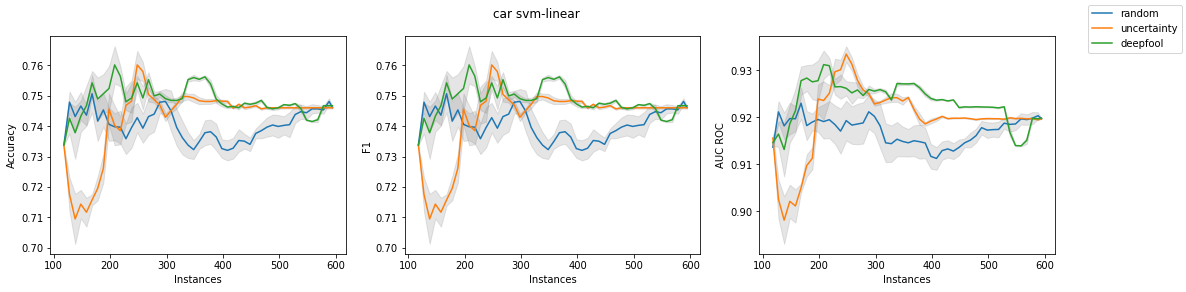

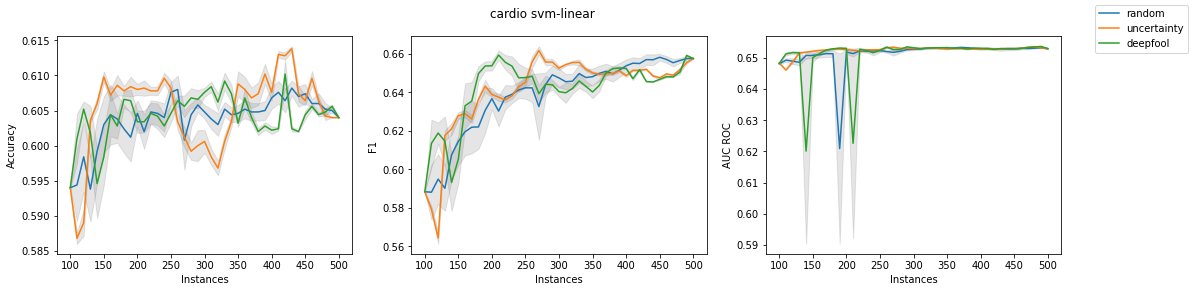

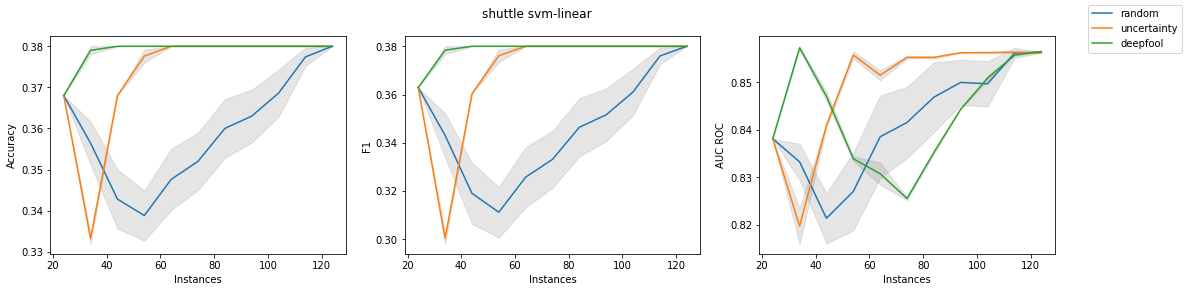

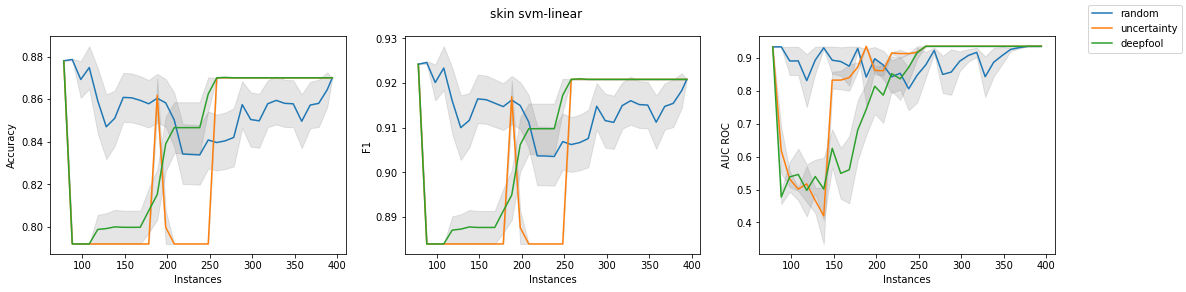

In [7]:
librun.plot(plots)